In [1]:
import numpy as np
import matplotlib.pyplot as plt
import debugger as db

from matplotlib import animation
from scipy.special import factorial

In [2]:
def hermite(x, n):
  """
  hermite:
    Hermite polinomial of order 'n', 
    defined over the real space grid 'x'.

  Parameters
  ----------
  x : np.ndarray
    Real space grid.
  n : int
    Order of the polinomial.

  Returns
  -------
  herm_pol: np.ndarray
    Hermite polinomial of order 'n'.
  """
  # Pre-condition: n>=0
  if n < 0:
    db.checkpoint(debug=True, msg=f"The order of the Hermite polynomial is not valid (n={n}, expected n>=0)", stop=True)

  # Coefficients set to 0 except for the one of order n.
  herm_coeffs = np.zeros(n + 1)
  herm_coeffs[n] = 1
  
  # Actual computation of the polinomial over the space grid.
  herm_pol = np.polynomial.hermite.hermval(x, herm_coeffs)
  return herm_pol

# ===========================================================================================================

def harmonic_wfc(x, n=0):
  """
  harmonic_wfc:
    Wavefunction of order 'n' for a harmonic potential, 
    defined over the real space grid 'x'.
  
    V(x) = 0.5 * m * omega * x**2
        
  Parameters
  ----------
  x : np.ndarray
    Spatial grid used for discretization
  n : int, optional
    Order of the wavefunction. By default 0 (ground state).

  Returns
  -------
  psi: np.ndarray
    Normalized wavefunction of order 'n'.
  """
  # Grid
  dx = x[1] - x[0]
  
  # Components of the analytical solution for stationary states.
  prefactor = 1 / np.sqrt(2**n * factorial(n)) * (1 / np.pi)**0.25
  exponential = np.exp(- (x**2) / 2)
  
  # Complete wavefunction, with normalization
  psi = prefactor * exponential * hermite(x, n)
  psi_normalized = psi / np.sqrt(np.sum(np.abs(psi)**2) * dx)
  
  return psi_normalized

In [3]:
class Param:
  """
  Param: 
    Container for holding all simulation parameters.
  """
  def __init__(self,
               xmax: float,
               num_x: int,
               tsim: float,
               num_t : int,
               im_time: bool = False) -> None:
    """
    __init__ : 
      Initialize simulation parameters.

    Parameters
    ----------
    xmax : float
      Maximum spatial value (half the simulation domain).
    num_x : int
      Number of spatial grid points.
    tsim : float
      Total simulation time.
    num_t : int
      Number of time steps.
    im_time : bool, optional
      Whether to use imaginary time evolution. Default is False.
    """
    # Initialization
    self.xmax = xmax
    self.num_x = num_x
    self.tsim = tsim
    self.num_t = num_t
    self.im_time = im_time

    # Infinitesimal quantities (space, time, momentum)
    self.dx = 2 * xmax / num_x
    self.dt = tsim / num_t
    self.dk = np.pi / xmax # defined like 1/x, with a coefficient coming from FT.
    
    # Spatial grid
    self.x = np.arange(-xmax + xmax / num_x, xmax, self.dx)

    # Momentum grid -> DONE FOR THE FFT, which wants the frequencies in this order!!!
    self.k = np.concatenate((np.arange(0, num_x / 2), np.arange(-num_x / 2, 0))) * self.dk
    
    # validation check
    self._validate()

  def _validate(self) -> None:
    """
    _validate :
      Check for common errors in parameter initialization.
    """
    if self.num_x <= 0 or self.num_t <= 0:
      db.checkpoint(debug=True, msg1="INITIALIZATION", msg2="ValueError: num_x and num_t must be positive integers.", stop=True)
    if self.xmax <= 0 or self.tsim <= 0:
      db.checkpoint(debug=True, msg1="INITIALIZATION", msg2="ValueError: xmax and tsim must be positive values.", stop=True)
      
# ===========================================================================================================

class Operators:
  """
  Container for holding operators and wavefunction coefficients.
  """
  def __init__(self, 
               res: int, 
               voffset: float = 0, 
               wfcoffset: float = 0, 
               n: int = 0, 
               q0_func=None, 
               par: Param = None) -> None:
    """
    __init__: 
      Initialize operator arrays and configure time-dependent potential 
      and wavefunction.

    Parameters
    ----------
    res : int
      Resolution of the spatial domain (number of grid point).
    voffset : float, optional
      Offset of the quadratic potential in real space. Default is 0.
    wfcoffset : float, optional
      Offset of the wavefunction in real space. Default is 0.
    n : int, optional
      Order of the Hermite polynomial. Default is 0.
    q0_func : callable, optional
      A function q0_func(t) defining the time-dependent offset q0(t). 
      Default is None.
    par : Param, optional
      Instance of the Param class containing simulation parameters, 
      used to initialize grid-related quantities. Default is None.
    """
    # Initialize empty complex arrays for potential, propagators, and wavefunction
    self.V = np.empty(res, dtype=complex)  # Potential operator
    self.R = np.empty(res, dtype=complex)  # Real-space propagator
    self.K = np.empty(res, dtype=complex)  # Momentum-space propagator
    self.wfc = np.empty(res, dtype=complex)  # Wavefunction coefficients

    # Energy history list to track energy over time
    self.energy_history = []
    
    # Store time-dependent offset function (default to no potential if None)
    self.q0_func = q0_func or (lambda t: 0)

    # Initialize potential and wavefunction if a Param instance is provided
    if par is not None:
      self._initialize_operators(par, voffset, wfcoffset, n)
      self.calculate_energy(par)

  def _initialize_operators(self, par: Param, voffset: float, wfcoffset: float, n: int) -> None:
    """
    _initialize_operators: 
      Initialize operators and wavefunction based on the provided parameters.

    Parameters
    ----------
    par : Param
      Simulation parameter instance containing grid and time information.
    voffset : float
      Offset of the quadratic potential in real space.
    wfcoffset : float
      Offset of the wavefunction in real space.
    n : int
      Order of the Hermite polynomial.
      
    Returns
    -----------
    None (acts in place).
    """
    # Initial time-dependent offset (at t=0)
    q0 = self.q0_func(0)

    # Quadratic potential with offset
    self.V = 0.5 * (par.x - voffset - q0) ** 2

    # Wavefunction based on a harmonic oscillator eigenstate
    self.wfc = harmonic_wfc(par.x - wfcoffset, n).astype(complex)

    # Coefficient for imaginary or real time evolution
    coeff = 1 if par.im_time else 1j

    # Momentum and real-space propagators
    self.K = np.exp(-0.5 * (par.k ** 2) * par.dt * coeff)
    self.R = np.exp(-0.5 * self.V * par.dt * coeff)

  def calculate_energy(self, par: Param) -> float:
    """
    calculate_energy:
      Calculate the energy <Psi|H|Psi>.

    Parameters
    ----------
    par : Param
      Parameters of the simulation

    Returns
    -------
    None (acts in place).
    """
    # Creating real, momentum, and conjugate wavefunctions.
    wfc_r = self.wfc
    wfc_k = np.fft.fft(wfc_r)
    wfc_c = np.conj(wfc_r)

    # Finding the momentum and real-space energy terms
    energy_k = 0.5 * wfc_c * np.fft.ifft((par.k ** 2) * wfc_k)
    energy_r = wfc_c * self.V * wfc_r

    # Integrating over all space (discrete sum weighted by grid spacing)
    energy_final = (sum(energy_k + energy_r).real) * par.dx

    # Store the energy in the history
    self.energy_history.append(energy_final)

In [4]:
def split_op(par: Param, opr: Operators) -> None:
  """
  split_op :
    Split operator method for time evolution.

  Parameters
  ----------
  par : Param
    Parameters of the simulation
  opr : Operators
    Operators of the simulation

  Returns
  -------
  None
  """
  # Initialize storage
  results = np.zeros((100, 2 * par.num_x)) # 1st half -> wfc in real space; 2nd half -> wfc in momentum space
  potential = np.zeros((100, par.num_x))
  avg_position = np.zeros(100)
  
  # Initialize jj for gif visualization
  jj = 0
  
  # Loop over the number of timesteps
  for i in range(par.num_t):
    # Update the time-dependent potential V(x, t)
    q0 = opr.q0_func(i * par.dt)
    opr.V = 0.5 * (par.x - q0) ** 2
    
    # Update the real space propagator
    coeff = 1 if par.im_time else 1j
    opr.R = np.exp(-0.5 * opr.V * par.dt * coeff)

    # Half-step in real space
    opr.wfc *= opr.R

    # Full step momentum space
    opr.wfc = np.fft.fft(opr.wfc)
    opr.wfc *= opr.K
    opr.wfc = np.fft.ifft(opr.wfc)

    # Final half-step in real space
    opr.wfc *= opr.R

    # Density for plotting and potential
    density = np.abs(opr.wfc) ** 2

    # Renormalization for imaginary time evolution
    if par.im_time:
      renorm_factor = np.sum(density * par.dx)
      if renorm_factor != 0.0:
        opr.wfc /= np.sqrt(renorm_factor)
      else:
        db.checkpoint(debug=True, msg1=f"RENORMALIZATION WARNING! Renorm factor too small at timestep {i}: {renorm_factor}", stop=False)

    # Saves exactly 100 snapshots
    if i % (par.num_t // 100) == 0 and jj < 100:
      # Save wfc in real and momentum space
      results[jj, 0:par.num_x] = np.real(density)
      results[jj, par.num_x:2 * par.num_x] = np.abs(np.fft.fft(opr.wfc)) ** 2
      
      # Save potential
      potential[jj, :] = opr.V
      
      # Save average position
      avg_position[jj] = np.sum(par.x * density) * par.dx

      # Update jj
      jj += 1

  return results, potential, avg_position

In [5]:
def plot_average_position(time, avg_position):
  """
  plot_average_position :
    Plot the average position of the particle over time.

  Parameters
  ----------
  time : np.ndarray
    Array of time values.
  avg_position : np.ndarray
    Array of average position values.

  Returns
  -------
  None
  """
  plt.figure(figsize=(8, 6))
  plt.plot(time, avg_position, label="Average position $\langle x(t) \\rangle$")
  plt.xlabel("Time (t)")
  plt.ylabel("Position (x)")
  plt.legend()
  plt.title("Average position of the particle over time")

  plt.grid(True)
  plt.show()

In [6]:
def gif_animation(par, density, potential, avg_position, filename='real_space_with_avg_position.gif'):
    """
    gif_animation:
      Creates an animated GIF showing the wave function, potential, and average position
      at each timestep.

    Parameters
    ----------
    par : Param
      Parameters of the simulation (contains spatial grid, etc.)
    density : numpy.ndarray
      Array of the wave function density at each timestep.
    potential : numpy.ndarray
      Array of the potential at each timestep.
    avg_position : numpy.ndarray
      Array of the average position of the particle at each timestep.
    filename : str, optional
      Name of the output GIF file. Default is 'real_space_with_avg_position.gif'.
    """
    # Set up the figure and axis for the animation
    fig, ax = plt.subplots()
    ax.set_xlim(-par.xmax, par.xmax)
    ax.set_ylim(0, 1.5)
    ax.set_xlabel("Position (x)")
    ax.set_ylabel("Probability Density |ψ(x)|^2")

    # Lines for the wave function, potential, and average position
    line_wfc, = ax.plot([], [], lw=2, label="Wave Function |ψ(x)|^2", color='blue')
    line_pot, = ax.plot([], [], lw=2, label="Potential V(x)", color='gray', linestyle='--')
    line_avg_pos, = ax.plot([], [], lw=2, label="Average Position", color='red', linestyle='-.')

    ax.legend()

    # Initialization function for the animation
    def init_line():
        line_wfc.set_data([], [])
        line_pot.set_data([], [])
        line_avg_pos.set_data([], [])
        return line_wfc, line_pot, line_avg_pos

    # Animation function to update the plot at each frame
    def animate(i):
        x = par.x
        y_wfc = density[i, :par.num_x]  # Extract density for frame i
        y_pot = potential[i, :]  # Extract potential from the stored potential array
        avg_pos = avg_position[i]  # Extract the average position for the current timestep

        # Set data for the wave function and potential
        line_wfc.set_data(x, y_wfc)
        line_pot.set_data(x, y_pot)

        # Update the average position line
        line_avg_pos.set_data([avg_pos, avg_pos], [0, 1.5])  # Vertical line from y=0 to y=1.5

        return line_wfc, line_pot, line_avg_pos

    # Create the animation
    anim = animation.FuncAnimation(
        fig, animate, init_func=init_line, frames=100, interval=20, blit=True
    )

    # Save the animation as a GIF
    writer = animation.PillowWriter(fps=10, metadata=dict(artist='Me'), bitrate=1800)
    anim.save(filename, writer=writer)
    
    # Close the figure to prevent it from displaying in the notebook
    plt.close(fig)
    
    # Final print statement
    print(f"Animation saved as '{filename}'")

In [7]:
# SIMULATION PARAMETERS

xmax = 10.0
num_x = 500
tsim = 50
num_t = 1000
im_time = False

# Initialize the Param object
par = Param(xmax, num_x, tsim, num_t, im_time)

# ===========================================================================================================

# INITIAL CONDITIONS

res = num_x
voffset = 0.0
wfcoffset = 0.0
n = 5
q0_func = lambda t: 5 * t / tsim 

# Initialize the Operators object
opr = Operators(res, voffset, wfcoffset, n, q0_func, par)

In [8]:
print(f"The final energy of the systems is: {opr.energy_history[-1]}")

The final energy of the systems is: 5.499999999999996


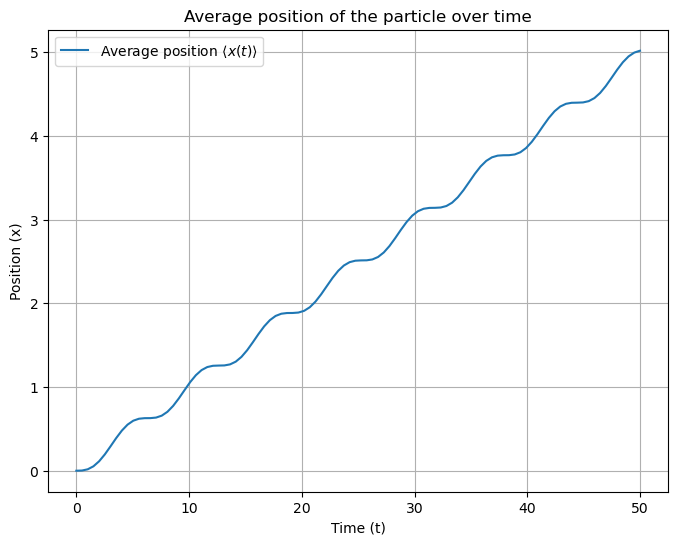

In [9]:
# Run the simulation and get the results
density, potential, avg_position = split_op(par, opr)

# Time array (100 elements)
time = np.linspace(0, par.tsim, 100)

plot_average_position(time, avg_position)

In [10]:
filename = "real_time_evolution.gif"
gif_animation(par, density, potential, avg_position, filename)

Animation saved as 'real_time_evolution.gif'


In [19]:
# SIMULATION PARAMETERS

xmax = 10.0
num_x = 500
tsim = 50
num_t = 1000
im_time = True

# Initialize the Param object
par = Param(xmax, num_x, tsim, num_t, im_time)

# ===========================================================================================================

# INITIAL CONDITIONS

res = num_x
voffset = 0.0
wfcoffset = 0.0
n = 0
q0_func = lambda t: 5*t / tsim 

# Initialize the Operators object
opr = Operators(res, voffset, wfcoffset, n, q0_func, par)

In [20]:
print(f"The final energy of the systems is: {opr.energy_history[-1]}")

The final energy of the systems is: 0.5000000000000006


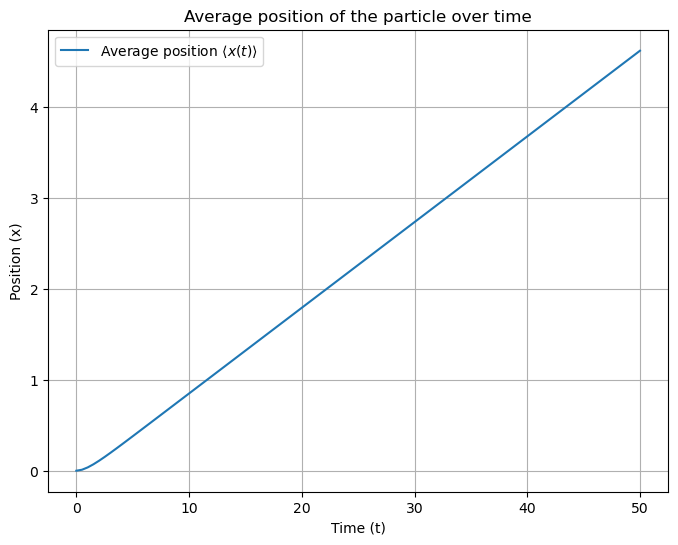

In [21]:
# Run the simulation and get the results
density, potential, avg_position = split_op(par, opr)

# Time array (100 elements)
time = np.linspace(0, par.tsim, 100)

plot_average_position(time, avg_position)

In [22]:
filename = "imaginary_time_evolution.gif"
gif_animation(par, density, potential, avg_position, filename)

Animation saved as 'imaginary_time_evolution.gif'
